In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import pickle
import math
import matplotlib.pyplot as plt
%matplotlib inline

### Load a data set.

In [2]:
df = pd.read_csv('/Users/akihiko/Documents/pastperf0621/TldByIO.txt', header=0)  

# Take care of the logging issues.
df = df[df.impressions > 0]
df.actions[df.actions > df.impressions] = df.impressions[df.actions > df.impressions]

In [3]:
df.head()

,tld,io_id,impressions,actions
0,0 - kfp - learn your numbers hd,44732,1,0
1,0 - painting the animals ipad,44732,13,0
2,00000000-0000-0000-0000-000000000000,52366,2508,0
3,00000000-0000-0000-0000-000000000000,54727,280,0
4,001ffe71-ec98-44b8-96a5-27e922c036b2,54182,1,0


## Bayesian inference with MatrixFactorization class.

In [4]:
import matrix_factorization as matfac

#### Initialize 'MatrixFactorization' class.

In [5]:
num_factor = 2
bias_scale = .1
factor_scale = math.sqrt(bias_scale / 2)
weight = df.impressions # Immportance weights on each observed matrix entry.
mf = matfac.MatrixFactorization(df.actions / df.impressions, df.tld.values, df.io_id.values,
                                num_factor, bias_scale, factor_scale, weight=weight)

#### Run Gibbs sampler. 

In [6]:
n_burnin = 0
n_mcmc = 300
n_update = 30
num_process = 1

_, sample_dict = mf.gibbs(n_burnin, n_mcmc, n_update, seed=1)

10 iterations have been completed.
The total increase in log posterior so far is 3.44e+04.
20 iterations have been completed.
The total increase in log posterior so far is 3.96e+04.
30 iterations have been completed.
The total increase in log posterior so far is 4.3e+04.
40 iterations have been completed.
The total increase in log posterior so far is 4.47e+04.
50 iterations have been completed.
The total increase in log posterior so far is 4.61e+04.
60 iterations have been completed.
The total increase in log posterior so far is 4.65e+04.
70 iterations have been completed.
The total increase in log posterior so far is 4.77e+04.
80 iterations have been completed.
The total increase in log posterior so far is 4.87e+04.
90 iterations have been completed.
The total increase in log posterior so far is 4.87e+04.
100 iterations have been completed.
The total increase in log posterior so far is 4.94e+04.
110 iterations have been completed.
The total increase in log posterior so far is 4.94e+04

#### Check the convergence.

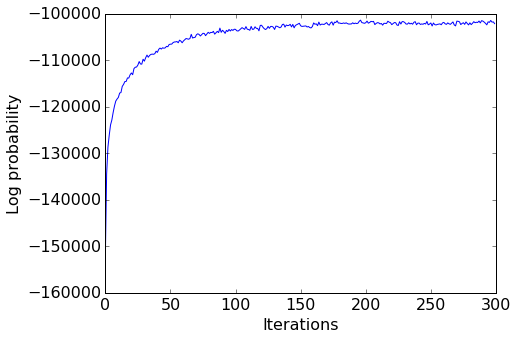

In [7]:
plt.figure(figsize=(7,5), dpi=80)
plt.rcParams['font.size'] = 16

plt.plot(sample_dict['logp'])
plt.xlabel('Iterations')
plt.ylabel('Log probability')

plt.show()

#### Obtain the posterior samples using 'compute_model_mean_sample' function, discarding the samples before the convergence.

In [8]:
y_hat_samples = mf.compute_model_mean_sample(df.tld.values, df.io_id.values, sample_dict, burnin=200)

#### Compare the observed CVR and model fit.

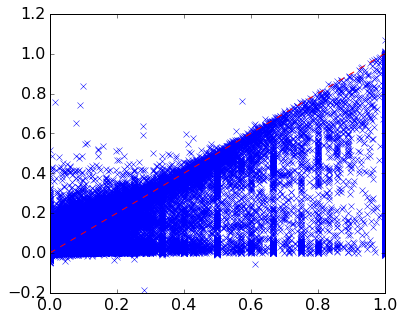

In [9]:
y_hat_post_mean = np.mean(y_hat_samples, axis=1)

plt.figure(figsize=(6,5), dpi=80)
plt.rcParams['font.size'] = 16

plt.plot(df.actions / df.impressions, y_hat_post_mean, 'x')
plt.plot([0, 1], [0, 1], '--r') # Add a 45 degree reference line.

plt.show()

## Compare the prediction and actual CVR of a test dataset.

#### Load a test data set.

In [10]:
df_test = pd.read_csv('/Users/akihiko/Documents/newperf0621/TldByIO.txt', header=0)

# Take care of the logging issues.
df_test = df_test[df_test.impressions > 0]
df_test.actions[df_test.actions.isnull()] = 0
df_test.actions[df_test.actions > df_test.impressions] = \
    df_test.impressions[df_test.actions > df_test.impressions]

df_test.head()

/Users/akihiko/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/akihiko/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,tld,io_id,impressions,actions
0,the-girl-who-ate-everything.com,1151,1,0.0
1,all-that-is-interesting.com,49500,27,0.0
2,what-character-are-you.com,50610,356,0.0
3,organizeyourselfskinny.com,44787,775,0.0
4,equipmenttraderonline.com,51124,2,0.0


#### Use 'compute_model_mean_sample' function to compute the predictive distribution for the test set.

In [11]:
y_samples = mf.compute_model_mean_sample(df_test.tld, df_test.io_id, sample_dict)
y_samples[y_samples < 0] = 0
y_samples[y_samples > 1] = 1

observed_cvr = df_test.actions / df_test.impressions
y_pred = np.nanmedian(y_samples, axis=1)
was_matched = np.logical_not(np.isnan(y_pred))

mf_error = np.mean(df_test.impressions * np.abs(y_pred[was_matched] - observed_cvr[was_matched])) \
    / np.mean(df_test.impressions)
print('The weighted mean absolute error is {:.3g}.'.format(mf_error))

Only 96.9 percent of the categories could be matched with the trained matrix
NaN indicates the unmatched rows.
The weighted mean absolute error is 0.00455.


/Users/akihiko/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:739: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


#### Plot the distribution of predicted and observed CVR.

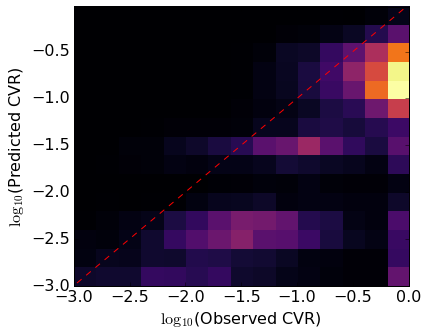

In [12]:
plt.figure(figsize=(6,5), dpi=80)
plt.rcParams['font.size'] = 16
was_matched = np.logical_not(np.isnan(y_pred))
observed_cvr = df_test.actions.values / df_test.impressions.values

# Ristrict to the observations with observed CVR > 10^-3.
is_nonzero = np.logical_and((observed_cvr > 10 ** -3), (y_pred > 10 ** -3))
observed_cvr_for_plot = observed_cvr[np.logical_and(was_matched, is_nonzero)]
y_pred_for_plot = y_pred[np.logical_and(was_matched, is_nonzero)]

plt.hist2d(np.log10(observed_cvr_for_plot), np.log10(y_pred_for_plot), bins=15, cmap='inferno')
plt.plot([-6,1], [-6,1], 'r--')
plt.xlabel(r'$\log_{10}$(Observed CVR)')
plt.ylabel(r'$\log_{10}$(Predicted CVR)')
plt.show()